#Set up

In [ ]:
#Import important libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

#Get data

In [ ]:
#Download the dataset
dataset = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv')

In [ ]:
#Change the columns name to a lower case
dataset.columns = dataset.columns.str.lower()

# Preparation
* Execute the preparation code from the starter notebook
* Split the dataset into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split funciton for that with random_state=1

Some of the features are encoded as numbers. Use the following code to de-code them:

In [ ]:
#Maping some information in the columns 
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

dataset.status = dataset.status.map(status_values)


home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

dataset.home = dataset.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

dataset.marital = dataset.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

dataset.records = dataset.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

dataset.job = dataset.job.map(job_values)

In [ ]:
#Prepare the numerical variables:
for c in ['income', 'assets', 'debt']:
    dataset[c] = dataset[c].replace(to_replace=99999999, value=0)

In [ ]:
#Remove clients with unknown default status
dataset = dataset[dataset.status != 'unk'].reset_index(drop=True)

In [ ]:
#Create the target variable
dataset['default'] = (dataset.status == 'default').astype(int)
del dataset['status']

In [ ]:
#split data into X and y variable
X = dataset.iloc[:,:-1]
y = dataset.iloc[:,-1].values


In [ ]:
#Split data into train, test and validation datasets 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= .40, random_state= 1)
X_test, X_validation, y_test, y_validation = train_test_split(X_test, y_test, test_size = .50, random_state = 1)

# Question 1
ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that


* For each numerical variable, use it as score and compute AUC with the "default" variable
* Use the training dataset for that

If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['expenses'])

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

* seniority
* time
* income
* debt

In [ ]:
#Numerical columns list
numerical_columns = ['seniority', 'time', 'age', 'expenses', 'income', 'assets', 'debt', 'price']

In [ ]:
#calculate AUC 
from sklearn.metrics import roc_auc_score

for column in numerical_columns:
    auc = roc_auc_score(y_train, X_train[column])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -X_train[column])
    print('%9s, %.3f' % (column, auc))

seniority, 0.699
     time, 0.555
      age, 0.574
 expenses, 0.507
   income, 0.671
   assets, 0.638
     debt, 0.503
    price, 0.514


Which numerical variable (among the following 4) has the highest AUC?

* income with 0.671

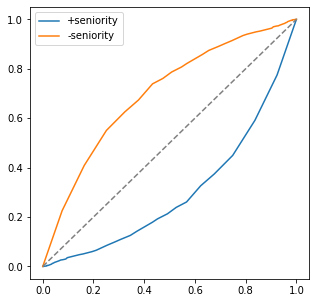

In [ ]:
#Roc_curve plot
from sklearn.metrics import roc_curve
plt.figure(figsize=(5, 5))

fpr, tpr, _ = roc_curve(y_train, X_train.seniority)
plt.plot(fpr, tpr, label='+seniority')

fpr, tpr, _ = roc_curve(y_train, -X_train.seniority)
plt.plot(fpr, tpr, label='-seniority')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--')

plt.legend()
plt.show()

We can see that there's separation in distribution of seniority
between positive and negative classes (this is what AUC tells us about)

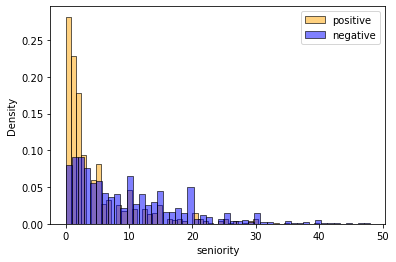

In [ ]:
#Distribution of seniority between positive and negative classes 
sns.histplot(X_train.seniority[y_train == 1],
             stat='density', bins=50,
             color='orange', alpha=0.5,
             label='positive')
sns.histplot(X_train.seniority[y_train == 0],
             stat='density', bins=50,
             color='blue', alpha=0.5,
             label='negative')

plt.legend()
plt.show()

For negative examples (blue) the values of seniority tend to be higher. That's why AUC is below 0.5 - the correlation is negative. 

If we revese the order by negating the values seniority, the positive examples
will tend to have higher values than negative.
That's why AUC of "-seniority" is above 0.5

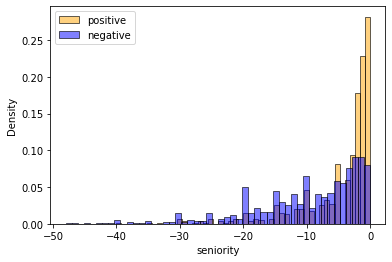

In [ ]:

sns.histplot(-X_train.seniority[y_train == 1],
             stat='density', bins=50,
             color='orange', alpha=0.5,
             label='positive')
sns.histplot(-X_train.seniority[y_train == 0],
             stat='density', bins=50,
             color='blue', alpha=0.5,
             label='negative')

plt.legend()
plt.show()

## Training the model
From now on, use these columns only:

['seniority', 'income', 'assets', 'records', 'job', 'home']

Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

In [ ]:
#From now on, use these columns only: ['seniority', 'income', 'assets', 'records', 'job', 'home']
X_train = X_train[['seniority', 'income', 'assets', 'records', 'job', 'home']]

In [ ]:
#Apply one-hot-encoding using DictVectorizer 
from sklearn.feature_extraction import DictVectorizer 

train_dict = X_train.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
dv.fit(train_dict)
X_train = dv.transform(train_dict)

In [ ]:
#Train the logistic regression with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [ ]:
#Preparing the validation dataset
X_validation = X_validation[['seniority', 'income', 'assets', 'records', 'job', 'home']]
validation_dict = X_validation.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
dv.fit(validation_dict)
X_validation = dv.transform(validation_dict)

In [ ]:
#Making prediction
y_pred = model.predict(X_validation)

In [ ]:
#accuracy_score
from sklearn.metrics import accuracy_score
accuracy_score(y_validation, y_pred)

0.7789001122334456

In [ ]:
y_pred = model.predict_proba(X_validation)[:, 1]

# Question 2
What's the AUC of this model on the validation dataset? (round to 3 digits)

* 0.512
* 0.612
* 0.712
* 0.812

In [ ]:
#Calculating the auc
roc_auc_score(y_validation, y_pred)

0.7810103212856382

# Question 3
Now let's compute precision and recall for our model.

Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
For each threshold, compute precision and recall
Plot them
At which threshold precision and recall curves intersect?

* 0.2
* 0.4
* 0.6
* 0.8

In [ ]:
def confusion_matrix_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)
    
    return df_scores

In [ ]:
df_scores = confusion_matrix_dataframe(y_validation, y_pred)

In [ ]:
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,253,638,0,0
10,0.1,240,457,13,181
20,0.2,205,280,48,358
30,0.3,164,159,89,479
40,0.4,136,93,117,545
50,0.5,101,45,152,593
60,0.6,68,21,185,617
70,0.7,42,9,211,629
80,0.8,22,4,231,634
90,0.9,4,0,249,638


In [ ]:
df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)

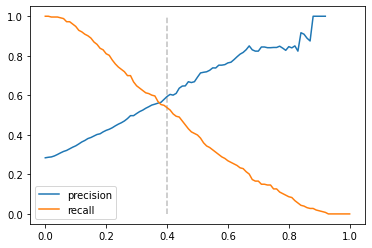

In [ ]:
plt.plot(df_scores.threshold, df_scores.p, label='precision')
plt.plot(df_scores.threshold, df_scores.r, label='recall')

plt.vlines(0.4, 0, 1, color='grey', linestyle='--', alpha=0.5)

plt.legend()
plt.show()

# Question 4
*Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

F1 = 2 * P * R / (P + R)

Where P is precision and R is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

* 0.1
* 0.3
* 0.5
* 0.7

In [ ]:
df_scores['f1'] = 2 * df_scores.p * df_scores.r / (df_scores.p + df_scores.r)

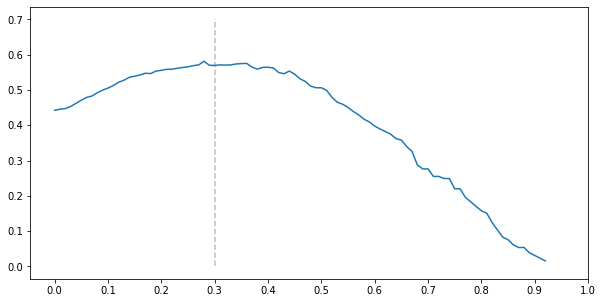

In [ ]:
plt.figure(figsize=(10, 5))

plt.plot(df_scores.threshold, df_scores.f1)
plt.vlines(0.3, 0, 0.7, color='grey', linestyle='--', alpha=0.5)

plt.xticks(np.linspace(0, 1, 11))
plt.show()

At which threshold F1 is maximal?

Answer: **0.3**

# Question 5

Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

KFold(n_splits=5, shuffle=True, random_state=1)

* Iterate over different folds of df_full_train
* Split the data into train and validation
* Train the model on train with these parameters:  
* LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
* Use AUC to evaluate the model on validation

How large is standard devidation of the AUC scores across different folds?

* 0.001
* 0.014
* 0.09
* 0.14

In [ ]:
##split data into train, test and validation dataset
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(dataset,random_state=1, test_size= .40)
test_set, validation_set = train_test_split(test_set, random_state = 1, test_size= 50)

In [ ]:
from sklearn.model_selection import KFold

In [ ]:
columns = ['seniority', 'income', 'assets', 'records', 'job', 'home']

In [ ]:
#Function to train a LogisticRegression model
def train(df_train, y_train, C=1.0):
    dicts = df_train[columns].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C)
    model.fit(X_train, y_train)

    return dv, model
#Function to make predictions
def predict(df, dv, model):
    dicts = df[columns].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [ ]:
scores = []

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(train_set):
    df_train = train_set.iloc[train_idx]
    df_val = train_set.iloc[val_idx]

    y_train = df_train.default.values
    y_val = df_val.default.values

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.818 +- 0.017


# Question 6
Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: [0.01, 0.1, 1, 10]
* Initialize KFold with the same parameters as previously
* Use these parametes for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which C leads to the best mean score?

* 0.01
* 0.1
* 1
* 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

In [ ]:
#Trainig a LogisticRegression with diferent values for C 
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
c_values = [0.01, 0.1, 1, 10]

for C in c_values:
    scores = []

    for train_idx, val_idx in kfold.split(train_set):
        df_train = train_set.iloc[train_idx]
        df_val = train_set.iloc[val_idx]

        y_train = df_train.default.values
        y_val = df_val.default.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%4s, %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=0.01, 0.807 +- 0.015
C= 0.1, 0.818 +- 0.016
C=   1, 0.818 +- 0.017
C=  10, 0.818 +- 0.017
